## Looking at the data, I wondered can we predict the "roast style" from the coffee's characteristics. Let's find out !

In [1]:
# standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import warnings
warnings.simplefilter('ignore')

# tensorflow
from tensorflow import keras as kr
from keras.utils import np_utils
from tqdm.keras import TqdmCallback

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# file
file = '../input/coffee-scrap-coffeereview/coffee_fix.csv'

# load data
use_cols = ['roast','aroma','acid','body','flavor','aftertaste']
df = pd.read_csv(file,usecols=use_cols)

# fill NULLs with 0 in coffee characteristics & 'Unknown' in roast
values = {'roast': 'Unknown', 'aroma': 0.0, 'acid': 0.0, 'body': 0.0, 'flavor': 0.0, 'aftertaste': 0.0}
df.fillna(values, inplace=True)

# encoding labels
le = LabelEncoder()
df['roast'] = le.fit_transform(df['roast'])

# view
print(f'Found {df.shape[0]} records with {len(le.classes_)} roast types')

Found 2282 records with 7 roast types


In [3]:
# list of classes
print("Roast Types: ", ', '.join(i for i in list(le.classes_)))

Roast Types:  Dark, Light, Medium, Medium-Dark, Medium-Light, Unknown, Very Dark


**Luckily everything is in numerical format, so we can get straight to feature engineering ...**

In [4]:
# feature engineering
x = df.iloc[:, 1:6]    # aroma, acid, body, flavor, aftertaste
y = df.iloc[:, :1]    # roast

# convert array to labelled data
''' getting the number of classes from the Label Encoder.
    If this field is not provided then the function will create n+1 classes
'''
y_cat = np_utils.to_categorical(y, num_classes=len(list(le.classes_)))

In [5]:
# training & test data split [90-10]
x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.10, random_state= np.random.randint(10))
print(f"Training Records = {x_train.shape[0]} | Validation Record {x_test.shape[0]} ")

Training Records = 2053 | Validation Record 229 


### Simple Keras Model

In [6]:
# define model params
input_shape = x_train.shape[1]                                                          # input shape is always the number features
output_shape = y_cat.shape[1]                                                           # output shape is the number of categories / classes we want the model to output (in this case its 3)
nodes = np.ceil(2 * input_shape / 3 + output_shape).astype(int)                         # as per the above rule
batch_size = np.ceil(len(x_train) / 8).astype(int)                                     # 1/16th of the total X_train [sending in small batch]

# build model
model = kr.models.Sequential()
# input layer
model.add(kr.layers.Dense(batch_size,input_shape=(input_shape,),activation='selu'))

# hidden layer
model.add(kr.layers.Dense(nodes,activation='selu'))
# dropout layer
model.add(kr.layers.Dropout(0.2))

# hidden layer
model.add(kr.layers.Dense(nodes,activation='selu'))
# dropout layer
model.add(kr.layers.Dropout(0.2))

# output layer
model.add(kr.layers.Dense(output_shape,activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summmary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 257)               1542      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2838      
_________________________________________________________________
dropout (Dropout)            (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 84        
Total params: 4,596
Trainable params: 4,596
Non-trainable params: 0
______________________________________________________

2022-11-09 03:09:23.625852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 03:09:23.626825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 03:09:23.978418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 03:09:23.979401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 03:09:23.980285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [7]:
# model fit params
epoch = 500

# for re-runs
gc.collect()
kr.backend.clear_session()

# fit the keras model on the dataset
hist = model.fit(x_train
                ,y_train
                ,epochs = epoch
                ,batch_size=batch_size
                ,shuffle=True
                ,validation_data=(x_test, y_test)
                ,verbose=0
                ,callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

2022-11-09 03:09:29.725692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Our model has achieved an accuracy of  69.70% in 500




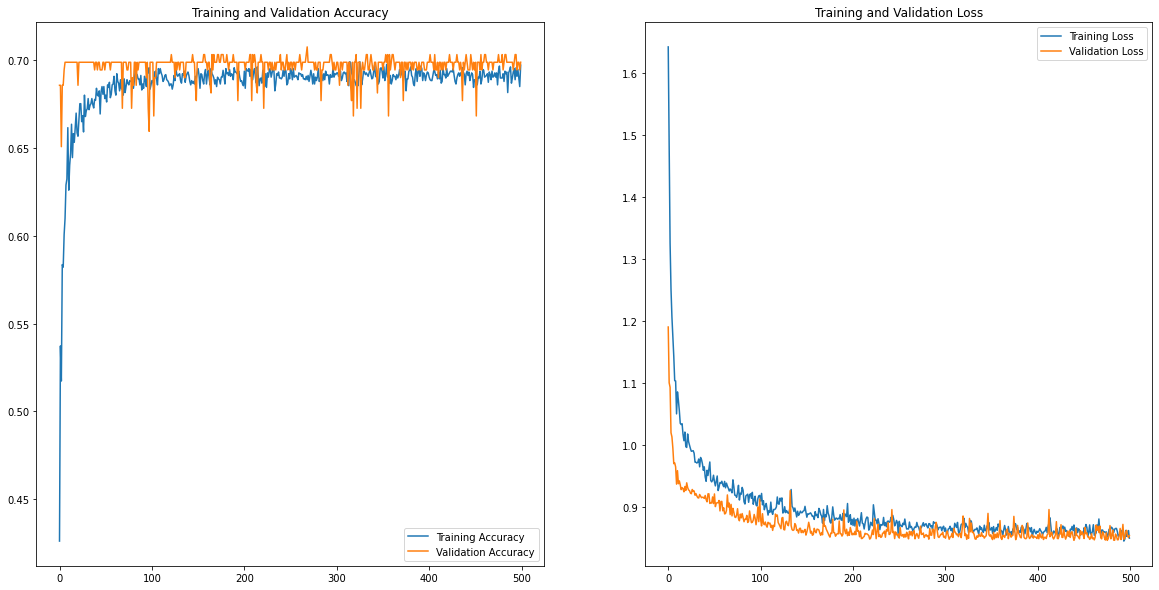

In [8]:
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"Our model has achieved an accuracy of  {acc} in {epoch}")
print('\n')
# visualize training results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# Confusion Matrix & Classfication Report
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

# classification report
class_names = []
for i in y['roast'].unique().tolist():
    if i == 6:
        pass
    else:
        class_names.append(le.inverse_transform([i])[0])
#class_names
print(classification_report(y_test_class, y_pred_class, target_names=class_names))

              precision    recall  f1-score   support

Medium-Light       0.00      0.00      0.00         0
      Medium       0.00      0.00      0.00        29
       Light       0.00      0.00      0.00        29
 Medium-Dark       0.00      0.00      0.00         7
     Unknown       0.70      1.00      0.83       157
        Dark       1.00      0.43      0.60         7

    accuracy                           0.70       229
   macro avg       0.28      0.24      0.24       229
weighted avg       0.51      0.70      0.58       229



### Simple LSTM Model

In [10]:
# reshaping x_train & x_test for efficient modelling
x_train_reshaped = np.reshape(np.array(x_train), (x_train.shape[0],x_train.shape[1],1))
x_test_reshaped = np.reshape(np.array(x_test), (x_test.shape[0],x_test.shape[1],1))

In [11]:
# define model params
input_shape = x_train_reshaped.shape[1]                                                         
output_shape = y_cat.shape[1]                                                           
nodes = np.ceil(2 * input_shape / 3 + output_shape).astype(int)                         
batch_size = np.ceil(len(x_train_reshaped) / 16).astype(int)   


# build model
LSTMModel = kr.models.Sequential()

# input layer
LSTMModel.add(kr.layers.LSTM(units=nodes, 
                           return_sequences=False,
                           input_shape=(input_shape,1),
                           activation='relu'))
# dropout layer
LSTMModel.add(kr.layers.Dropout(0.2))

# output layer
LSTMModel.add(kr.layers.Dense(output_shape
                             ,activation='softmax'))

# compile
LSTMModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summary
LSTMModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 11)                572       
_________________________________________________________________
dropout (Dropout)            (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 84        
Total params: 656
Trainable params: 656
Non-trainable params: 0
_________________________________________________________________


In [12]:
# epoch
epoch = 100

# for re-running
gc.collect()
kr.backend.clear_session()

# fit/train model
'''using the same epoch setting as above'''
hist = LSTMModel.fit(x_train_reshaped, 
                    y_train, 
                    epochs=epoch,
                    batch_size=batch_size,
                    verbose=0,
                    shuffle=True,
                    callbacks=[TqdmCallback(verbose=0)],
                    validation_data=(x_test_reshaped, y_test))

0epoch [00:00, ?epoch/s]

Our model has achieved an accuracy of  68.24% in 100




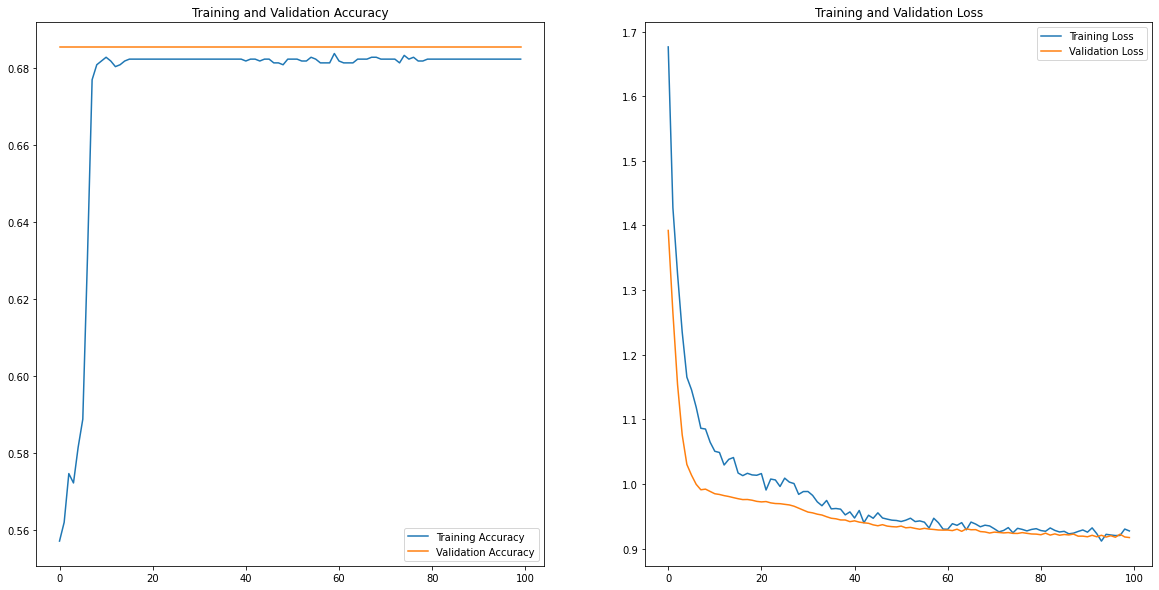

In [13]:
# accuracy
acc_lstm = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"Our model has achieved an accuracy of  {acc_lstm} in {epoch}")

print('\n')

# visualize training results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# Confusion Matrix & Classfication Report
y_pred = LSTMModel.predict(x_test_reshaped)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

# classification report
class_names = []
for i in y['roast'].unique().tolist():
    if i == 6 or i == 0:
        pass
    else:
        class_names.append(le.inverse_transform([i])[0])

#view 
print(classification_report(y_test_class, y_pred_class, target_names=class_names))

              precision    recall  f1-score   support

Medium-Light       0.00      0.00      0.00        29
      Medium       0.00      0.00      0.00        29
       Light       0.00      0.00      0.00         7
 Medium-Dark       0.69      1.00      0.81       157
     Unknown       0.00      0.00      0.00         7

    accuracy                           0.69       229
   macro avg       0.14      0.20      0.16       229
weighted avg       0.47      0.69      0.56       229



### Conclusion: So, yeah I believe we certainly can predict the "roast type" from the coffee characteristics ...